In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]


def apply_boxcox_transform(series, series_name):
    """
    Apply Box-Cox transformation to a series.
    Returns transformed series and lambda parameter.
    """
    print(f"\nApplying Box-Cox transformation to {series_name}...")
    
    # Check if series has positive values
    min_val = series.min()
    shift = 0
    
    if min_val <= 0:
        shift = abs(min_val) + 1
        print(f"  Series has non-positive values (min={min_val:.4f})")
        print(f"  Applying shift of {shift:.4f} to make all values positive")
        series_shifted = series + shift
    else:
        series_shifted = series.copy()
    
    try:
        transformed, lambda_param = boxcox(series_shifted)
        print(f"  Box-Cox lambda: {lambda_param:.4f}")
        print(f"  Original range: [{series.min():.4f}, {series.max():.4f}]")
        print(f"  Transformed range: [{transformed.min():.4f}, {transformed.max():.4f}]")
        
        return pd.Series(transformed, index=series.index), lambda_param, shift
    except Exception as e:
        print(f"  ERROR: Box-Cox transformation failed: {e}")
        print(f"  Using original series without transformation")
        return series, None, 0


def inverse_boxcox_transform(transformed_series, lambda_param, shift):
    """
    Apply inverse Box-Cox transformation.
    """
    if lambda_param is None:
        return transformed_series
    
    try:
        original = inv_boxcox(transformed_series, lambda_param)
        # Remove the shift that was applied before transformation
        original = original - shift
        return original
    except Exception as e:
        print(f"  ERROR: Inverse Box-Cox transformation failed: {e}")
        return transformed_series


def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False


def prepare_exog_data(train_df, test_df, target_indicator):
    print(f"\nPreparing exogenous variables for {target_indicator}...")
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    return train_df[available_features].copy(), test_df[available_features].copy(), available_features


def clean_exog_data(train_exog, test_exog):
    print(f"Cleaning exogenous data...")
    print(f"  Initial shapes - Train: {train_exog.shape}, Test: {test_exog.shape}")
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    varying_cols = [c for c in train_exog.columns if train_exog[c].nunique() > 1]
    train_exog = train_exog[varying_cols]
    test_exog = test_exog[varying_cols]
    test_exog = test_exog[train_exog.columns]
    print(f"  Final shapes - Train: {train_exog.shape}, Test: {test_exog.shape}")
    print(f"  Remaining missing values - Train: {train_exog.isnull().sum().sum()}, Test: {test_exog.isnull().sum().sum()}")
    return train_exog, test_exog


def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3, verbose=True):
    best_aic = float('inf')
    best_order = None
    best_model = None
    tried_orders = []

    print(f"\nRunning ARIMA grid search...")
    print(f"Series length: {len(series)}, Exog shape: {exog.shape}")

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    if verbose:
                        print(f"  Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog)
                    fitted = model.fit()
                    if verbose:
                        print(f"    Success: AIC = {fitted.aic:.2f}")
                    if fitted.aic < best_aic:
                        best_aic, best_order, best_model = fitted.aic, (p, d, q), fitted
                    tried_orders.append((p, d, q, fitted.aic))
                except Exception as e:
                    if verbose:
                        print(f"    Failed ARIMA({p},{d},{q}): {str(e)[:100]}")
                    continue

    print(f"\nBest model found: ARIMA{best_order} with AIC = {best_aic:.2f}")
    print(f"Total successful fits: {len(tried_orders)}")
    return best_model, best_order, best_aic


def forecast_indicator_with_exog(train_df, test_df, indicator, max_p=3, max_d=2, max_q=3, use_boxcox=True):
    print(f"\n{'='*60}\nFORECASTING: {indicator}\n{'='*60}")

    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None

    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    if len(train_series) < 10:
        print(f"ERROR: Insufficient training data for {indicator}")
        return None

    # Apply Box-Cox transformation
    lambda_param = None
    shift = 0
    if use_boxcox:
        train_series_transformed, lambda_param, shift = apply_boxcox_transform(train_series, indicator)
    else:
        print("\nSkipping Box-Cox transformation (use_boxcox=False)")
        train_series_transformed = train_series.copy()

    try:
        train_exog, test_exog, exog_features = prepare_exog_data(train_df, test_df, indicator)
        train_exog, test_exog = train_exog.loc[train_series_transformed.index], test_exog.loc[test_series.index]
        train_exog, test_exog = clean_exog_data(train_exog, test_exog)
        if train_exog.shape[1] == 0:
            print(f"WARNING: No exogenous variables for {indicator}")
            return None
    except Exception as e:
        print(f"ERROR preparing exogenous: {e}")
        return None

    is_stationary = check_stationarity(train_series_transformed, f"{indicator} (transformed)" if use_boxcox else indicator)

    try:
        model, order, aic = auto_arima_with_exog(train_series_transformed, train_exog, max_p, max_d, max_q)
        if model is None:
            print(f"ERROR: No ARIMA model for {indicator}")
            return None

        steps = min(len(test_series), len(test_exog))
        print(f"  Forecasting {steps} steps ahead")
        
        # Get forecast on transformed scale
        forecast_transformed = model.forecast(steps=steps, exog=test_exog.iloc[:steps])
        ci_transformed = model.get_forecast(steps=steps, exog=test_exog.iloc[:steps]).conf_int()

        # Inverse Box-Cox transform to original scale
        if use_boxcox and lambda_param is not None:
            print("\nApplying inverse Box-Cox transformation to forecasts...")
            forecast = inverse_boxcox_transform(forecast_transformed, lambda_param, shift)
            forecast_lower = inverse_boxcox_transform(ci_transformed.iloc[:, 0].values, lambda_param, shift)
            forecast_upper = inverse_boxcox_transform(ci_transformed.iloc[:, 1].values, lambda_param, shift)
        else:
            forecast = forecast_transformed
            forecast_lower = ci_transformed.iloc[:, 0].values
            forecast_upper = ci_transformed.iloc[:, 1].values

        # Compare with actual values on original scale
        actual = test_series.iloc[:steps]
        mae = np.mean(np.abs(forecast - actual))
        rmse = np.sqrt(np.mean((forecast - actual) ** 2))

        # Fix MAPE mask alignment
        actual_np, forecast_np = actual.to_numpy(), np.asarray(forecast)
        mask = actual_np != 0
        mape = np.mean(np.abs((actual_np[mask] - forecast_np[mask]) / actual_np[mask])) * 100 if mask.any() else np.inf

        print(f"\nAccuracy Metrics (on original scale):\n  MAE: {mae:.4f}\n  RMSE: {rmse:.4f}\n  MAPE: {mape:.2f}%")

        # Ensure save folder
        os.makedirs("arima_models", exist_ok=True)
        
        # Save model with transformation parameters
        model_info = {
            'model': model,
            'lambda_param': lambda_param,
            'shift': shift,
            'use_boxcox': use_boxcox
        }
        with open(f"arima_models/{indicator}_arima_model.pkl", "wb") as f:
            pickle.dump(model_info, f)
        print(f"Model saved to arima_models/{indicator}_arima_model.pkl")

        return {
            'model': model, 'order': order, 'aic': aic,
            'forecast': forecast, 'forecast_lower': forecast_lower,
            'forecast_upper': forecast_upper, 'actual': actual,
            'mae': mae, 'rmse': rmse, 'mape': mape,
            'is_stationary': is_stationary, 'exog_features': exog_features,
            'train_length': len(train_series), 'test_length': len(actual),
            'lambda_param': lambda_param, 'shift': shift, 'use_boxcox': use_boxcox
        }

    except Exception as e:
        print(f"ERROR fitting ARIMA for {indicator}: {e}")
        import traceback
        traceback.print_exc()
        return None


def plot_forecast_results(results, indicator, train_df, test_df):
    if results is None:
        return
    plt.figure(figsize=(15, 8))
    train_series = train_df[indicator].dropna()
    train_plot = train_series.tail(min(50, len(train_series)))
    train_dates = train_df.loc[train_plot.index, 'date']
    plt.plot(train_dates, train_plot.values, label='Training', color='blue', alpha=0.7)

    actual = results['actual']
    test_dates = test_df.loc[actual.index, 'date'].iloc[:len(actual)]
    plt.plot(test_dates, actual.values, label='Actual', color='green', linewidth=2, marker='o', markersize=4)

    forecast = results['forecast']
    forecast_dates = test_df.loc[actual.index, 'date'].iloc[:len(forecast)]
    plt.plot(forecast_dates, forecast, label='Forecast', color='red', linewidth=2, marker='s', markersize=4)

    plt.fill_between(forecast_dates, results['forecast_lower'], results['forecast_upper'],
                     alpha=0.3, color='red', label='95% CI')
    
    boxcox_str = f" (Box-Cox λ={results['lambda_param']:.3f})" if results['use_boxcox'] and results['lambda_param'] is not None else ""
    plt.title(f'{indicator} - ARIMA{results["order"]}{boxcox_str}\n'
              f'MAE:{results["mae"]:.4f} RMSE:{results["rmse"]:.4f} MAPE:{results["mape"]:.2f}%',
              fontsize=14)
    plt.xlabel('Date'); plt.ylabel('Value'); plt.legend(); plt.grid(alpha=0.3); plt.xticks(rotation=45)
    if len(train_dates) and len(test_dates):
        plt.axvline(x=test_dates.iloc[0], color='gray', linestyle='--', alpha=0.7)
    plt.tight_layout(); plt.show()


def run_time_series_forecasting_selected(train_selected, test_selected, financial_indicators=None, 
                                        plot_results=True, use_boxcox=True):
    print("=" * 80)
    print("TIME SERIES FORECASTING WITH SELECTED FEATURES")
    if use_boxcox:
        print("Box-Cox Transformation: ENABLED")
    else:
        print("Box-Cox Transformation: DISABLED")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    train_df, test_df = train_selected.copy(), test_selected.copy()
    train_df['date'], test_df['date'] = pd.to_datetime(train_df['date']), pd.to_datetime(test_df['date'])

    available = [i for i in financial_indicators if i in train_df.columns and i in test_df.columns]
    print(f"Indicators to forecast: {available}")

    all_results, forecasted = {}, pd.DataFrame({'date': test_df['date'].copy()})
    for ind in available:
        res = forecast_indicator_with_exog(train_df, test_df, ind, use_boxcox=use_boxcox)
        if res:
            all_results[ind] = res
            steps = len(res['forecast'])
            forecasted[f'{ind}_forecast'] = np.nan
            forecasted[f'{ind}_lower'] = np.nan
            forecasted[f'{ind}_upper'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_forecast')] = res['forecast'] if isinstance(res['forecast'], np.ndarray) else res['forecast'].values
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_lower')] = res['forecast_lower']
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_upper')] = res['forecast_upper']
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_actual')] = res['actual'].values
            if plot_results: plot_forecast_results(res, ind, train_df, test_df)

    return all_results, forecasted

In [2]:
train_selected = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_selected = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

TIME SERIES FORECASTING WITH SELECTED FEATURES
Box-Cox Transformation: ENABLED
Indicators to forecast: ['10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']

FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to 10_year_rate...
  Box-Cox lambda: 0.4557
  Original range: [1.5000, 15.3200]
  Transformed range: [0.4453, 5.4169]

Preparing exogenous variables for 10_year_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

10_year_rate (transformed) Stationarity Test:
ADF Statistic: -0.870948
p-value: 0.797389
Series is non-stationary

Running ARIMA grid search...
Series length

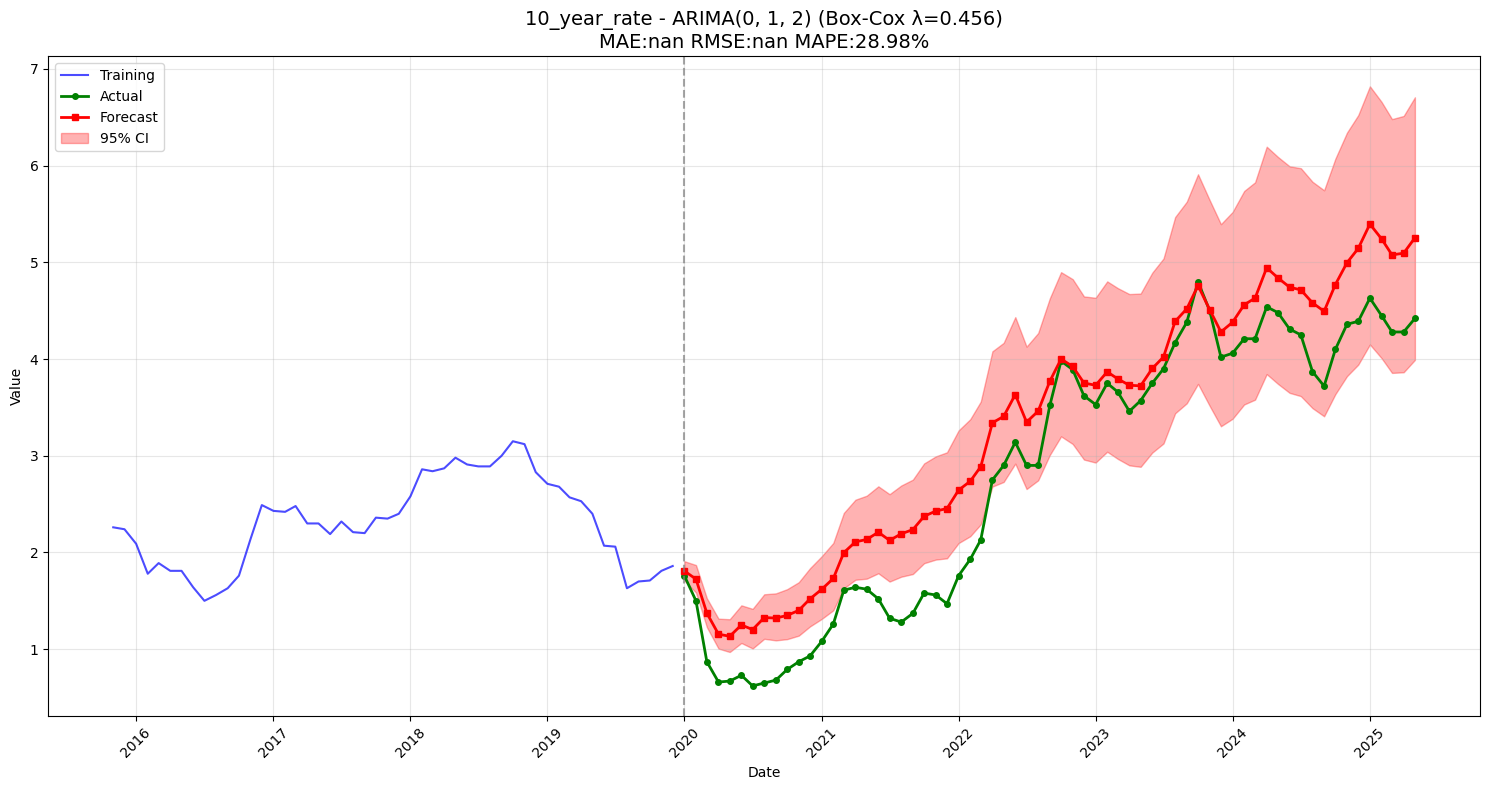


FORECASTING: share_price
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to share_price...
  Box-Cox lambda: 0.0796
  Original range: [3.5064, 128.5203]
  Transformed range: [1.3194, 5.9277]

Preparing exogenous variables for share_price...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

share_price (transformed) Stationarity Test:
ADF Statistic: -0.117343
p-value: 0.947683
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 2505.34
  Trying ARIMA order: (0,0,1)
    Success: AIC = -1309.19
  Trying ARIMA order: (0,0,2)
    Success: AIC = -1492.43
  Trying ARI

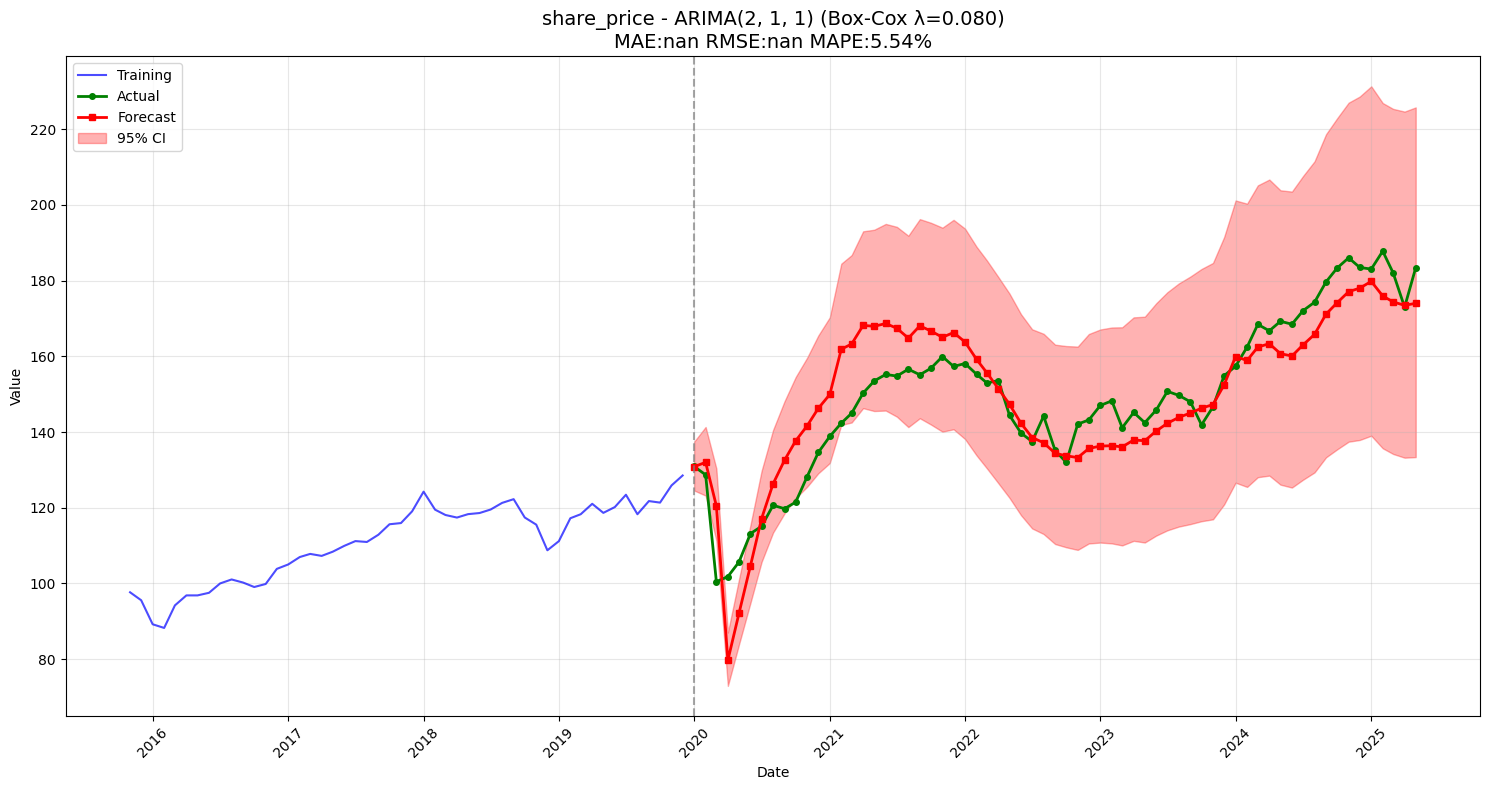


FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to unemployment_rate...
  Box-Cox lambda: -0.1029
  Original range: [3.4000, 10.8000]
  Transformed range: [1.1498, 2.1106]

Preparing exogenous variables for unemployment_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

unemployment_rate (transformed) Stationarity Test:
ADF Statistic: -3.078218
p-value: 0.028208
Series is stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 924.79
  Trying ARIMA order: (0,0,1)
    Success: AIC = -2823.61
  Trying ARIMA order: (0,0,2)
    Success: AIC = -2924.06

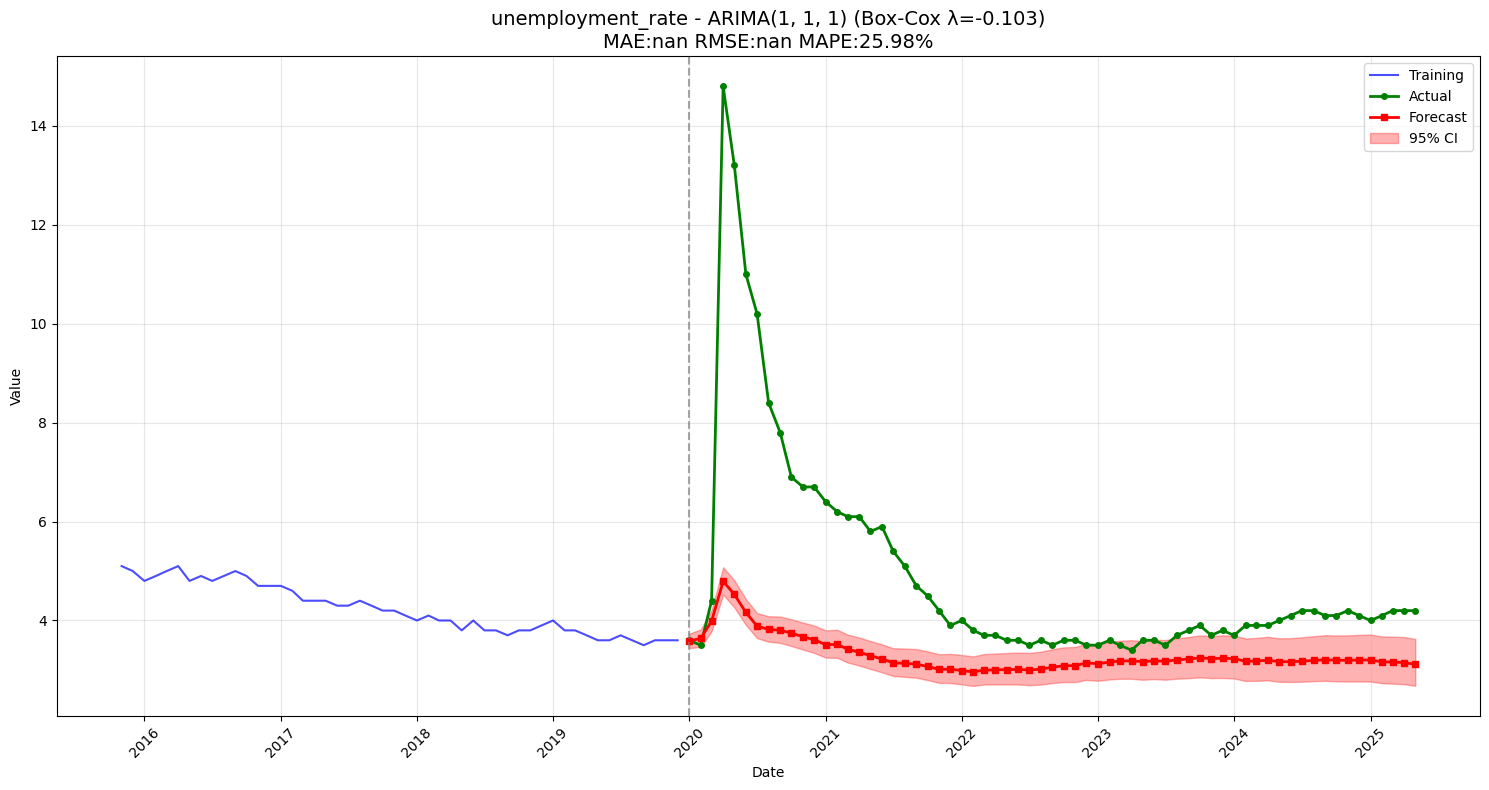


FORECASTING: PPI
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to PPI...
  Box-Cox lambda: 0.2159
  Original range: [27.2000, 366.6000]
  Transformed range: [4.8187, 11.9377]

Preparing exogenous variables for PPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

PPI (transformed) Stationarity Test:
ADF Statistic: -1.030444
p-value: 0.741999
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 2793.26
  Trying ARIMA order: (0,0,1)
    Success: AIC = -661.17
  Trying ARIMA order: (0,0,2)
    Success: AIC = -630.83
  Trying ARIMA order: (0,0,3)
    Su

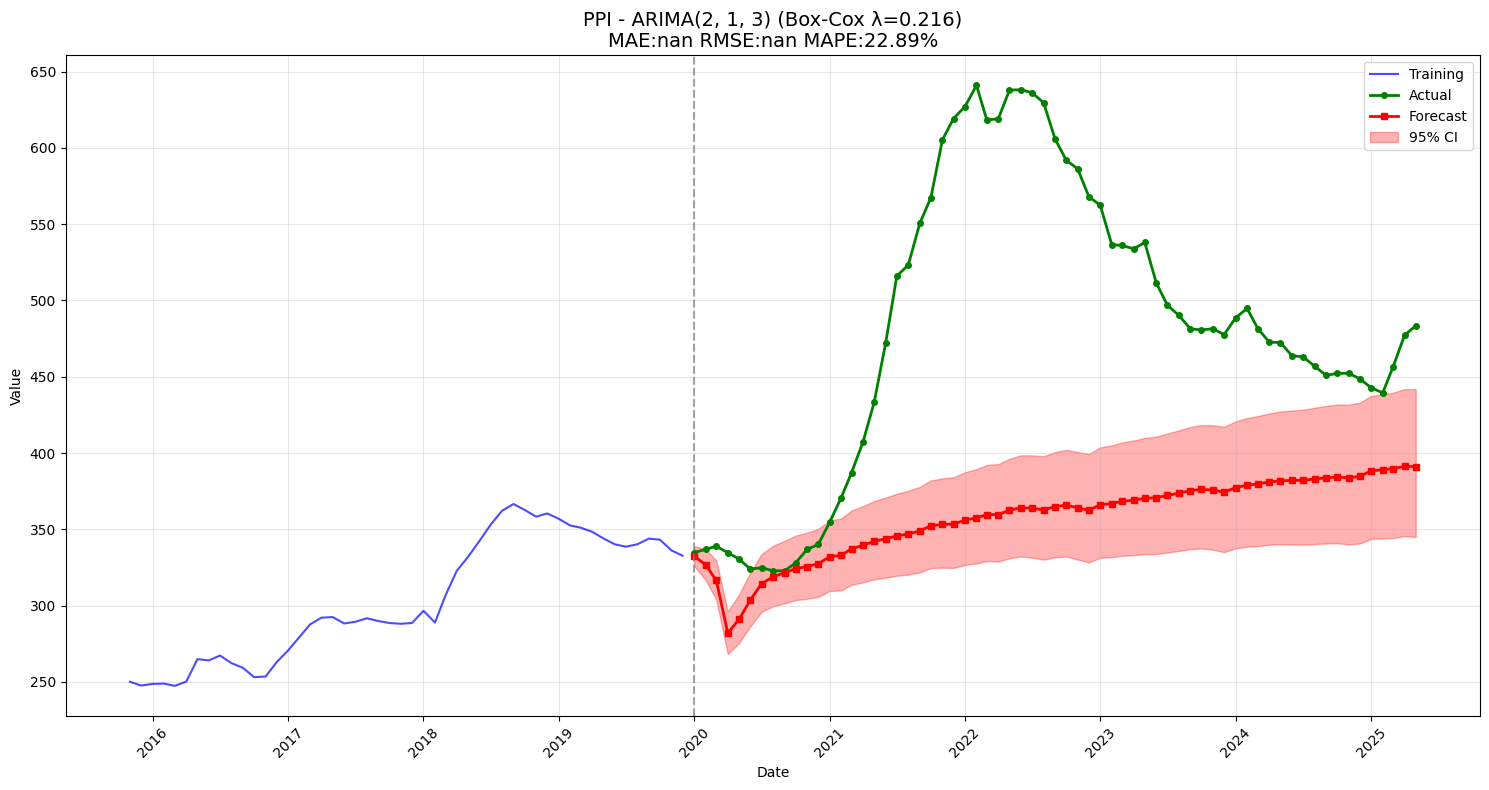


FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to OECD_CLI_index...
  Box-Cox lambda: 12.8533
  Original range: [94.7733, 103.8127]
  Transformed range: [1985355314564016149364736.0000, 6402799079569460459208704.0000]

Preparing exogenous variables for OECD_CLI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

OECD_CLI_index (transformed) Stationarity Test:
ADF Statistic: -0.679654
p-value: 0.851949
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 72353.50
  Trying ARIMA order: (0,0,1)
    Success: AIC = 68403.22
  Trying A

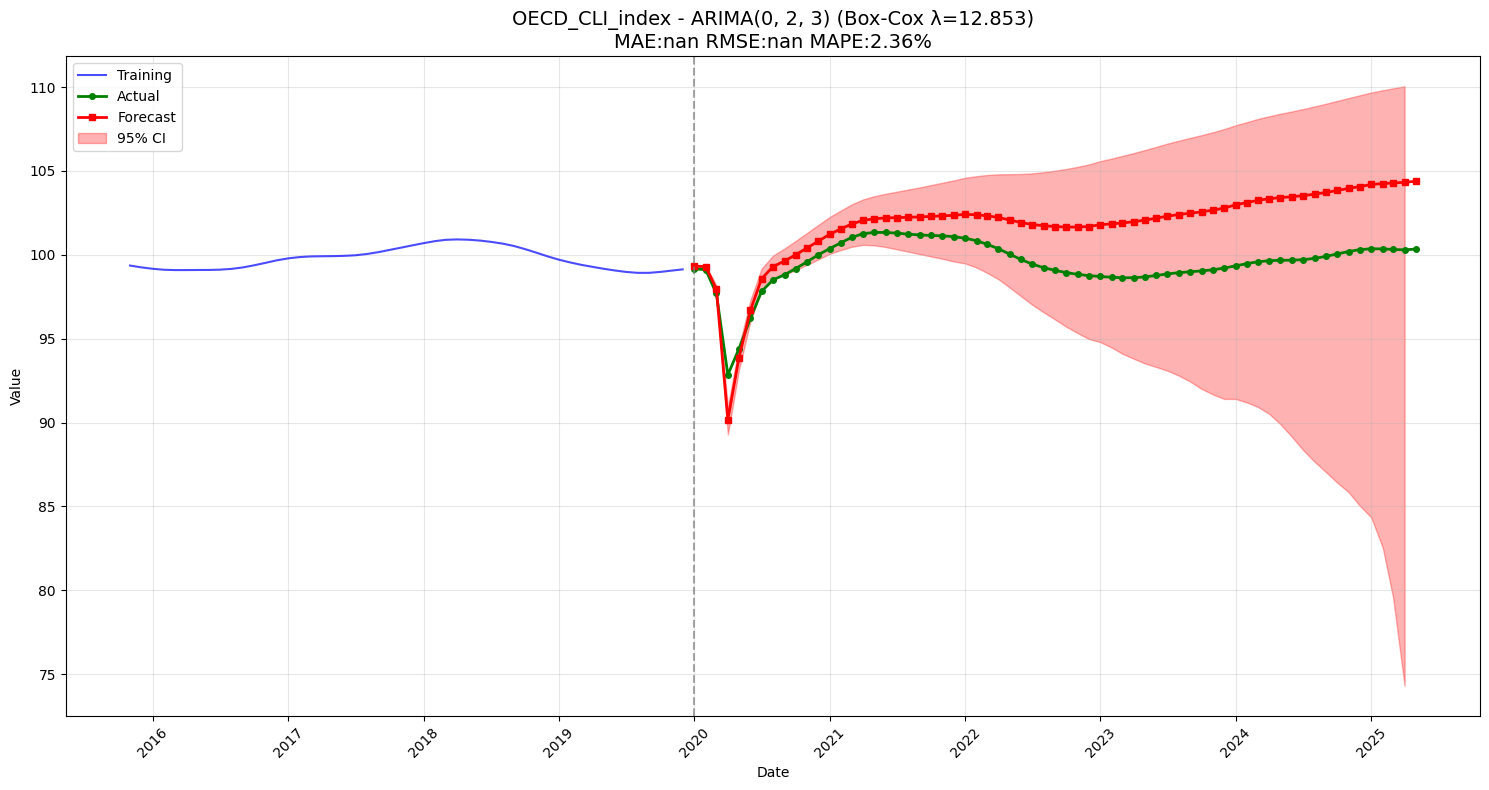


FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

Applying Box-Cox transformation to CSI_index...
  Box-Cox lambda: 2.2412
  Original range: [51.7000, 112.0000]
  Transformed range: [3088.4141, 17467.0861]

Preparing exogenous variables for CSI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

CSI_index (transformed) Stationarity Test:
ADF Statistic: -2.627378
p-value: 0.087470
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 13746.41
  Trying ARIMA order: (0,0,1)
    Success: AIC = 10178.85
  Trying ARIMA order: (0,0,2)
    Success: AIC = 10171.72
  Trying 

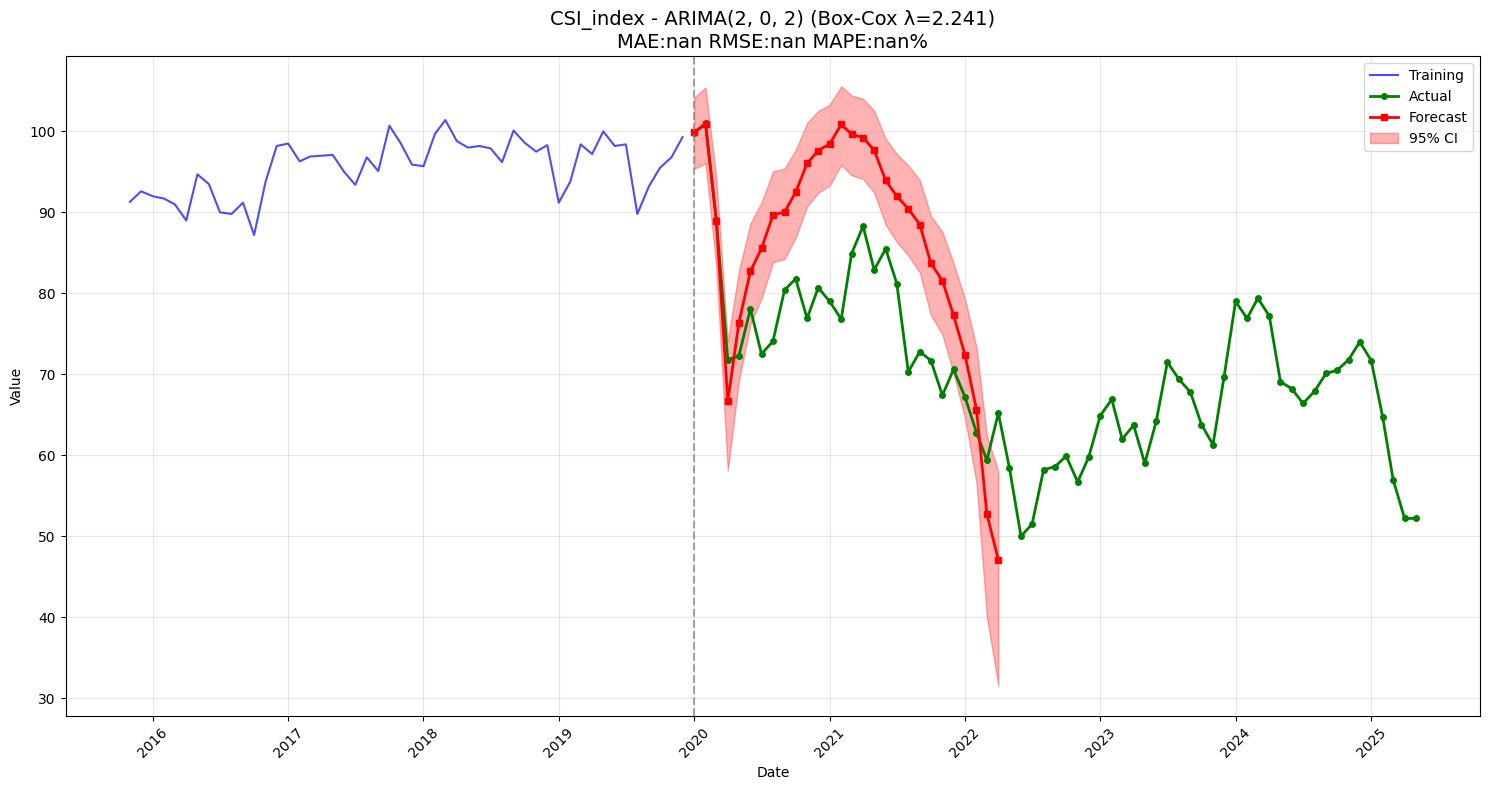


FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

Applying Box-Cox transformation to gdp_per_capita...
  Box-Cox lambda: 0.5391
  Original range: [24556.0000, 63360.0000]
  Transformed range: [429.7728, 717.6588]

Preparing exogenous variables for gdp_per_capita...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (64, 29)
  Final shapes - Train: (635, 29), Test: (64, 29)
  Remaining missing values - Train: 0, Test: 0

gdp_per_capita (transformed) Stationarity Test:
ADF Statistic: -0.536846
p-value: 0.884624
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 5329.16
  Trying ARIMA order: (0,0,1)
    Success: AIC = 1872.64
  Trying ARIMA order: (0,0,2)
    Success: AIC 

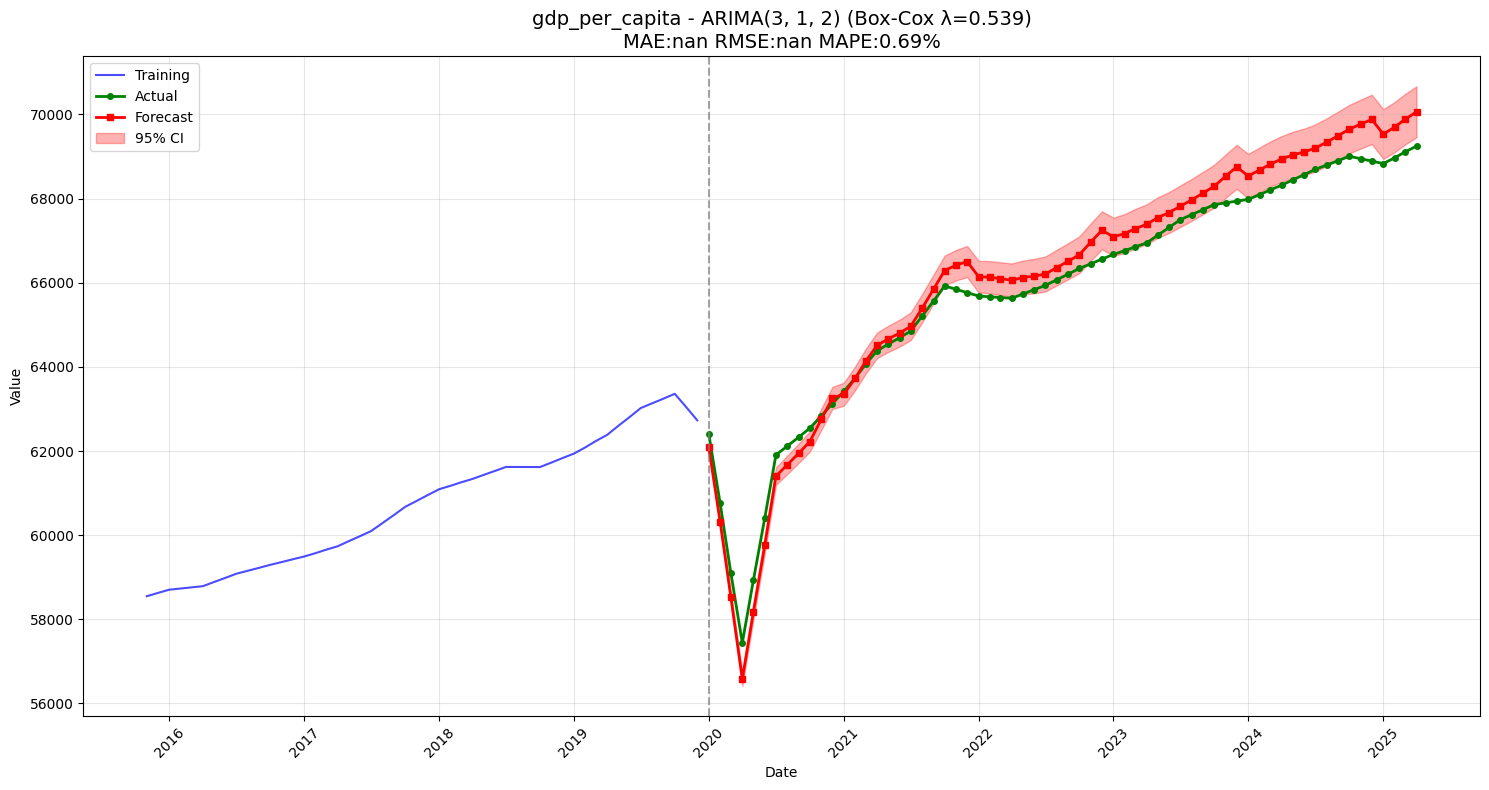

In [3]:
# Run forecasting on your selected datasets
all_results, forecasted_values = run_time_series_forecasting_selected(
    train_selected=train_selected,
    test_selected=test_selected,
    plot_results=True
)

# # Analyze performance
# performance_summary = analyze_forecast_performance(all_results)

# # Save results
# save_forecast_results(all_results, forecasted_values, 'my_forecast_results')